# Convergence Plots

## Dependencies

In [2]:
import json  # noqa: EXE002
import re
import time
from collections import defaultdict
from pathlib import Path
from pprint import pprint

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd


## Parameters

In [ ]:
RESULTS_DIR: Path = Path() / ".." / "data" / "02_results"
OUT_DIR: Path = (
    Path() / ".." / "data" / f"{time.strftime("%Y%m%d%H%M%S")}_convergence"
)
OUT_DIR.mkdir(exist_ok=True, parents=True)

## Locating Result Data

In [ ]:

result_paths: dict[str, dict[str, Path]] = {}

res = {
    "bounds": "bounds.csv",
    "dual_solver": "dual_solver.csv",
    "runtime": "runtime.json",
}

for rdir in RESULTS_DIR.iterdir():
    if not rdir.is_dir():
        continue
    result_paths[rdir.name] = {}
    for k, v in res.items():
        p = rdir / v
        if not p.exists():
            msg = f"File {p} not found"
            raise FileNotFoundError(msg)
        result_paths[rdir.name][k] = p

def natural_sort(text: str) -> list[int | str]:
    """Sort alphanumerical strings naturally."""
    def a2i(_text: str) -> int | str:
        return int(_text) if _text.isdigit() else _text
    return [a2i(t) for t in re.split(r"(\d+)", text)]

result_paths = {
    k: result_paths[k]
    for k in sorted(result_paths.keys(), key=natural_sort)
}

pprint(result_paths)  # noqa: T203

{'20250203225306_WB5_t06_n03_dsddip': {'bounds': PosixPath('../data/02_results/20250203225306_WB5_t06_n03_dsddip/bounds.csv'),
                                       'dual_solver': PosixPath('../data/02_results/20250203225306_WB5_t06_n03_dsddip/dual_solver.csv'),
                                       'runtime': PosixPath('../data/02_results/20250203225306_WB5_t06_n03_dsddip/runtime.json')}}


## Arrange Data

In [5]:
lagrange_markers = {}

for label, paths in result_paths.items():
    ds_path = paths.get("dual_solver")
    if ds_path:
        ds_df = pd.read_csv(paths["dual_solver"], sep="\t")
        lagrange_markers[label] = list(ds_df.i.unique().tolist())
    else:
        lagrange_markers[label] = []

In [ ]:
lower_bounds = {}

for label, paths in result_paths.items():
    bounds_df = pd.read_csv(paths["bounds"], sep="\t")
    # TODO: Which upper bound to use?
    ub = bounds_df["ub_r"].array[-1]
    lbs = bounds_df["lb"].div(ub).tolist()
    # TODO: How to consider last iteration?
    lbs.pop()
    lower_bounds[label] = lbs

np.float64(35736.62880225438)

In [ ]:
runtimes = {}

for label, paths in result_paths.items():
    with paths["runtime"].open() as runtime_file:
        runtime_data = runtime_file.read()
        runtimes[label] = json.loads(runtime_data)

iter_durations = defaultdict(list)
iterations = {}

for label, runtime in runtimes.items():
    iter_list = [i+1 for i in range(len(lower_bounds[label]))]
    iterations[label] = iter_list
    for i in iter_list:
        duration = sum(
            value for key, value in runtime.items()
            if f"i{i}" == key.split("_")[-1]
        )
        iter_durations[label].append(duration)

# Determine the cumulative duration of iterations
iter_durations_cum = {}
for label, durations in iter_durations.items():
    iter_durations_cum[label] = [
        sum(durations[:i]) for i in range(1, len(durations)+1)
    ]

## Plot

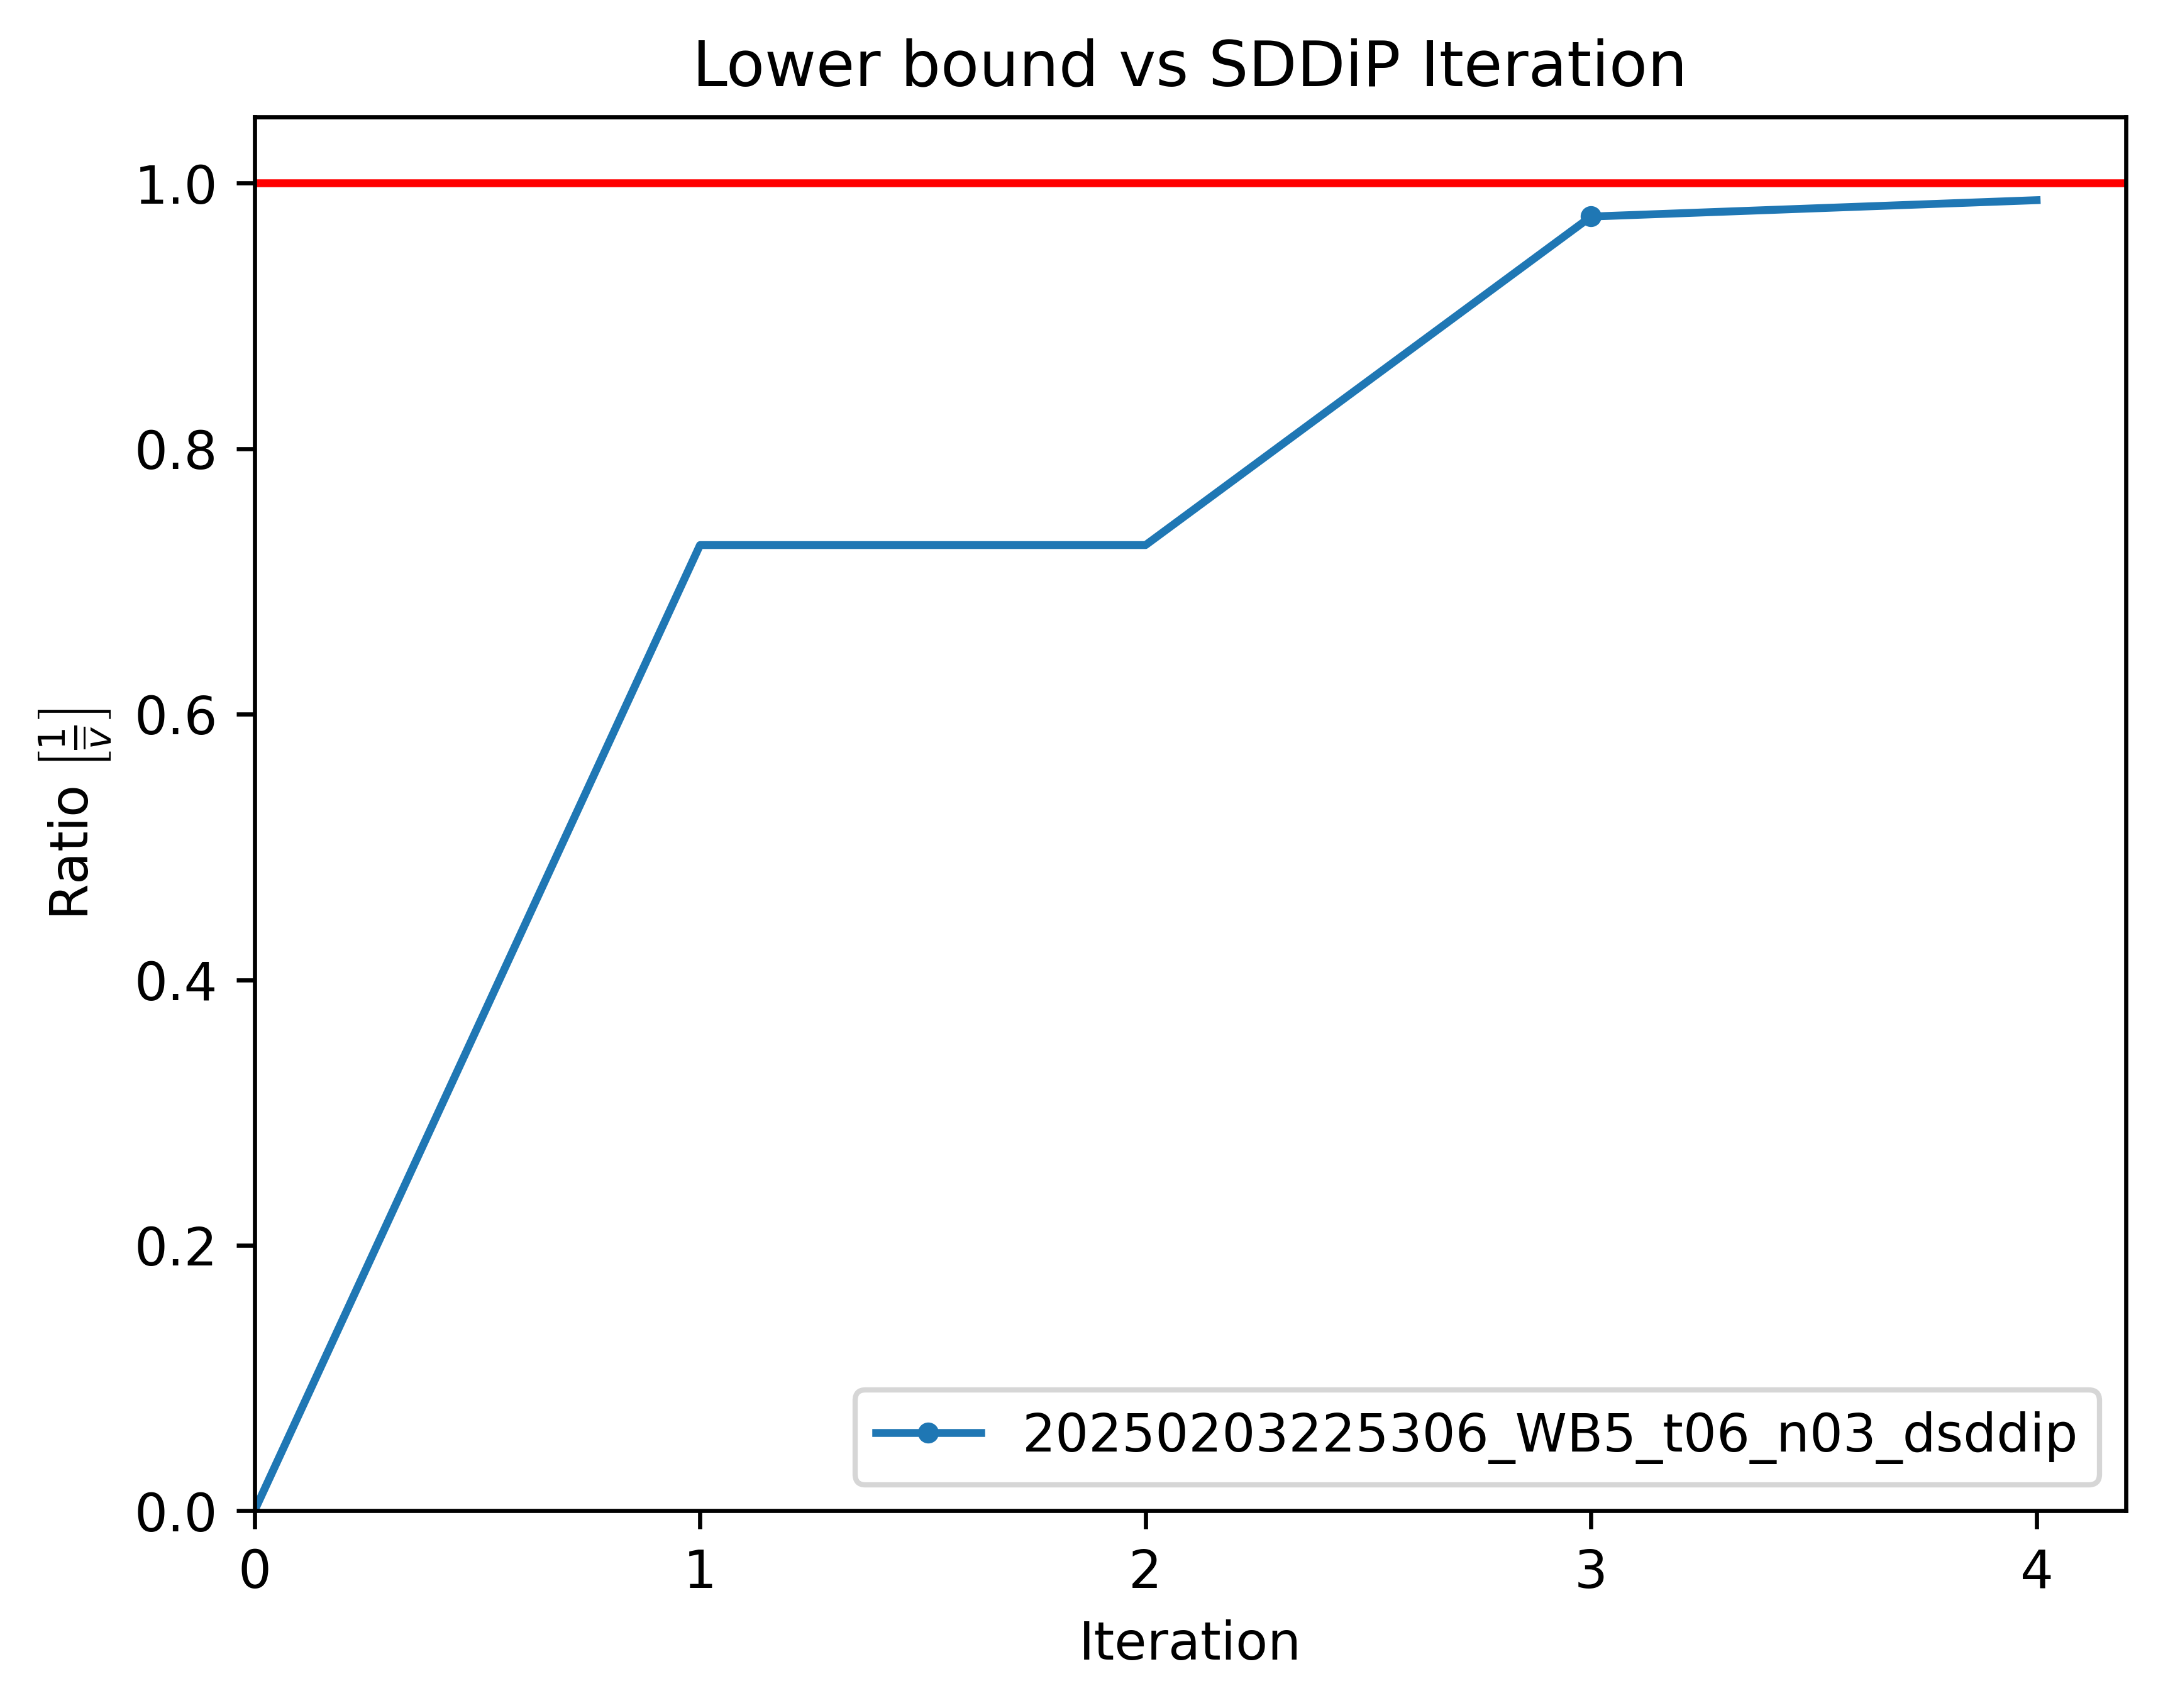

In [ ]:
fig = plt.figure(dpi= 600, facecolor="w", edgecolor="k")
ax = fig.gca()
ax.xaxis.get_major_locator().set_params(integer=True) # type: ignore

plt.axhline(y=1, color="r", linestyle="-")

for label in result_paths:
    values = [0] + lower_bounds[label]
    iterations =list(range(len(values)))
    markers = lagrange_markers[label]
    if markers and iterations[-1] + 1 < markers[-1]:
        markers.pop()
    plt.plot(iterations, values, ".", ls="-", markevery=markers, label=label)

ax.set(
    xlabel="Iteration",
    ylabel=r"Ratio $\left[\frac{1}{\overline{v}}\right]$"
)
plt.title("Lower bound vs SDDiP Iteration")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend(loc=4)

plt.savefig(OUT_DIR / "convergence_iterations.png")
plt.show()

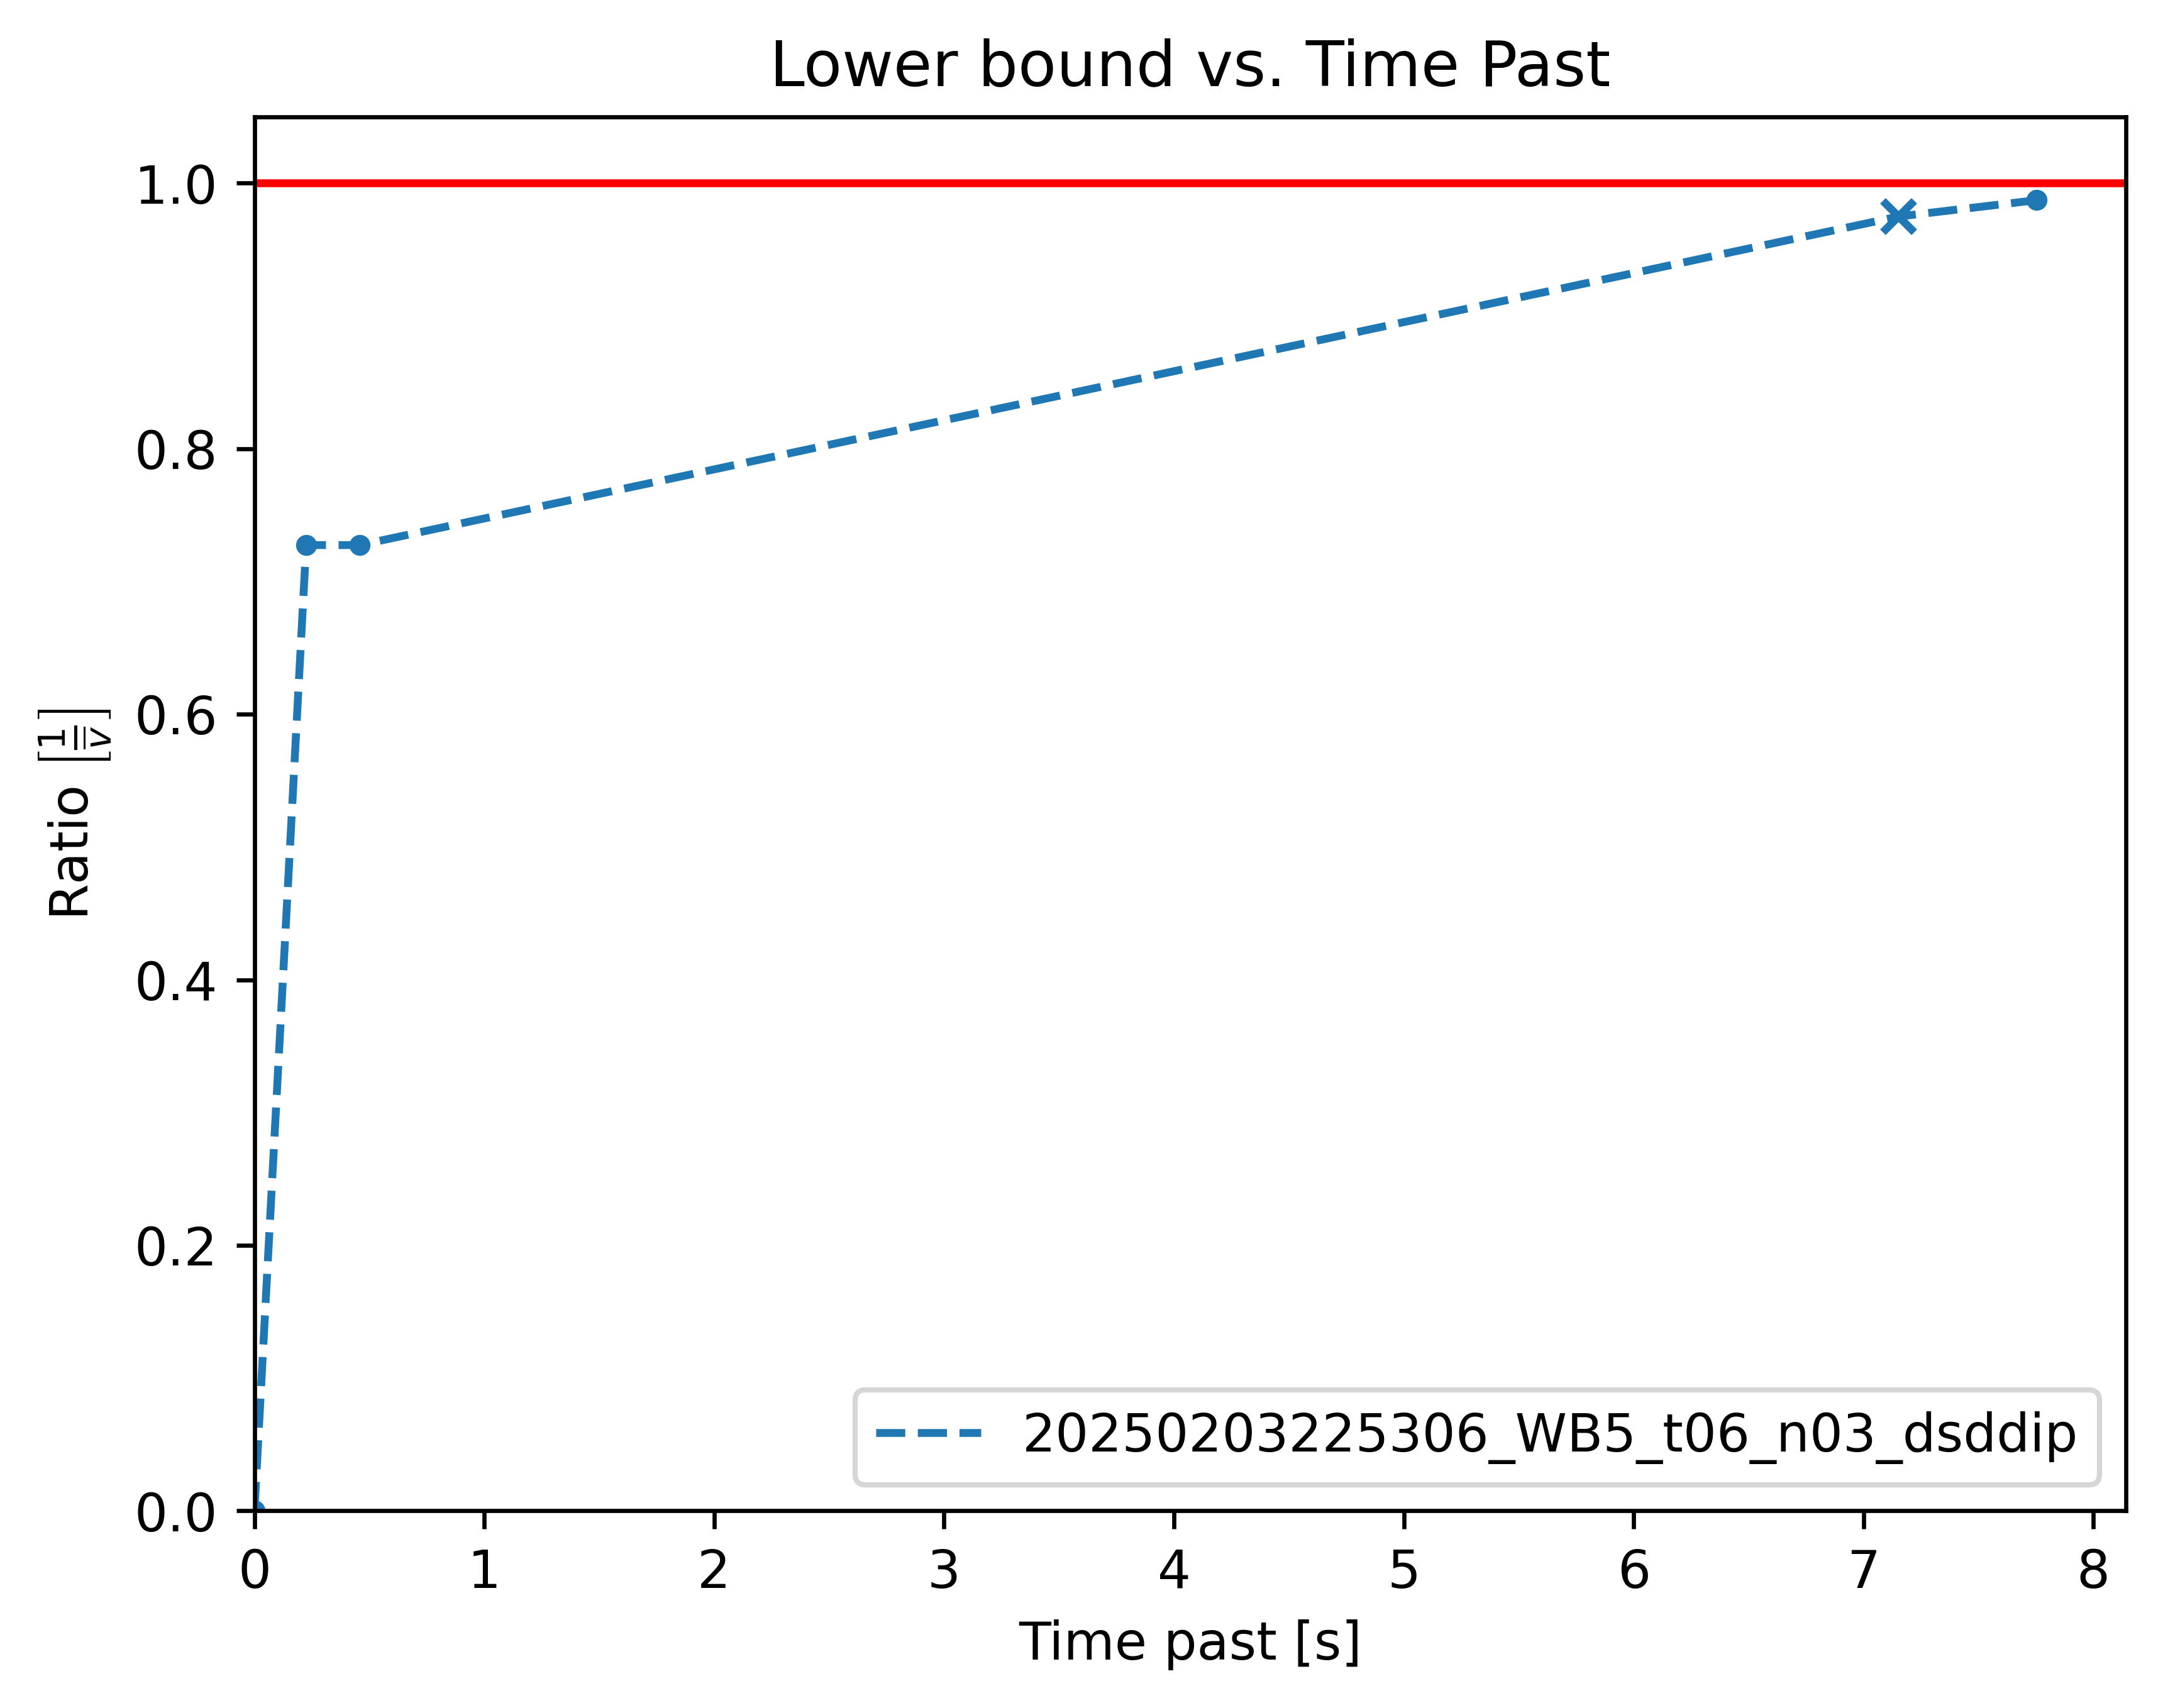

In [9]:
fig = plt.figure(dpi= 600, facecolor="w", edgecolor="k")
ax = fig.gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.axhline(y=1, color="r", linestyle="-")

for label, color in zip(
    result_paths.keys(), mcolors.TABLEAU_COLORS.keys(), strict=False
):
    values = [0] + lower_bounds[label]
    iterations =list(range(len(values)))
    durations = [0] + iter_durations_cum[label]
    markers = lagrange_markers[label]
    if markers and iterations[-1] + 1 < markers[-1]:
        markers.pop()
    plt.plot(durations, values, ls="--", label=f"{label}")
    for i in range(len(values)):
        if i in markers:
            plt.scatter(durations[i], values[i], color=color, marker="x")
        else:
            plt.scatter(durations[i], values[i], color=color, marker=".")


ax.set(
    xlabel="Time past [s]",
    ylabel=r"Ratio $\left[\frac{1}{\overline{v}}\right]$"
)
plt.title("Lower bound vs. Time Past")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend(loc=4)

plt.savefig(OUT_DIR / "convergence_time.png")
plt.show()